In [19]:
pip install opencv-contrib-python==3.4.2.16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **TRAINING**

In [20]:
# Import modules
#from scipy.cluster.vq import *
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
import pylab as pl
from sklearn.metrics import confusion_matrix, accuracy_score
#import confmat as cfmat
import cv2 as cv
import numpy as np
import os
from imutils import paths
import pickle
%matplotlib inline
from tqdm import tqdm
import pandas as pd


In [22]:
dataset_path = '/content/drive/My Drive/Model_Datasets/X_test'
categories = os.listdir(dataset_path)
print("Training path: ", dataset_path)
print("Training categories: ", categories)

Training path:  /content/drive/My Drive/Model_Datasets/X_test
Training categories:  ['65.jpg', '30.jpg', '32.jpg', '35.jpg', '253.jpg', '254.jpg', '232.jpg', '261.jpg', '192.jpg', '310.jpg', '246.jpg', '31.jpg', '245.jpg', '255.jpg', '36.jpg', '108.png', '127.png', '88.png', '106.png', '105.png', '149.png', '152.png', '28.png', '138.png', '45.png', '157.png', '39.png', '76.png', '114.png', '145.png', '151.png', '170.png', '81.png', '85.png', '123.png', '72.png', '70.png', '63.png', '60.png', '26.png', '20.png', '84.png', '125.png', '158.png', '117.png', '64.png', '109.png', '57.png', '19.png', '165.png', '78.png', '132.png', '15.png', '160.png', '159.png', '44.png', '8.png', '1.png', '17.png', '122.png', '56.png', '67.png', '146.png', '46.png', '166.png', '156.png', '121.png', '153.png', '73.png', '10.png', '163.png', '140.png', '97.png', '40.png', '118.png', '51.png', '69.png', '23.png', '154.png', '133.png', '100.png', '41.png', '147.png', '134.png', '22.png', '120.png', '124.png', '

In [26]:
from glob import glob
train = glob('/content/drive/My Drive/Model_Datasets/X_test/*.png', recursive=True)

In [28]:
# Detect SIFT Keypoints
sift = cv.xfeatures2d.SIFT_create()

In [29]:
def output(kp,input):
  kpImg = cv.drawKeypoints(input, kp, im)
  plt.imshow(im, cmap='gray')
  plt.axis("off")
  #plt.title("Image number "+str(IMAGE_N)+" Keypoints")
  plt.show()

In [27]:
print(train[0])

/content/drive/My Drive/Model_Datasets/X_test/108.png


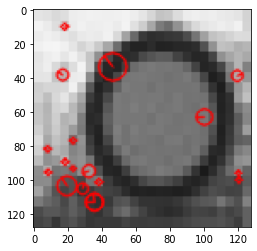

(<matplotlib.image.AxesImage at 0x7f8f6e0db860>, None)

In [32]:
img  = cv.imread(train[25])
im = cv.resize(img, (128,128),interpolation = cv.INTER_NEAREST)
gray = cv.cvtColor(im,cv.COLOR_BGR2GRAY)

kp = sift.detect(gray,None)
img2 = cv.drawKeypoints(gray,kp,None,(255,0,0),4)
plt.imshow(img2),plt.show()


In [33]:
des_list = []
desc_list=[]
print("Calculating all the descriptors and keypoints...")
for image_path in tqdm(train):
    #print("Calculating for image ["+ image_path +"]")
    img  = cv.imread(image_path)
    im = cv.resize(img, (128,128),interpolation = cv.INTER_NEAREST)
    gray = cv.cvtColor(im,cv.COLOR_BGR2GRAY) # Converts from one color space to another (grayscale)
    #gray=im
    kp,des = sift.detectAndCompute(gray,None)
    desc_list.append(des)
    des_list.append((image_path, des))
    #output(kp,gray)
print("\nDone!")

  0%|          | 0/329 [00:00<?, ?it/s]

Calculating all the descriptors and keypoints...


100%|██████████| 329/329 [02:32<00:00,  2.15it/s]


Done!


In [ ]:
# Stack all the descriptors vertically in a numpy array
print("Stacking all the descriptors in a numpy array...")
descriptors = des_list[0][1]
#descriptors=pd.transpose(descriptors)
for image_path, descriptor in tqdm(des_list[1:]):
    descriptors = np.vstack((descriptors, descriptor))
print("\nDone!")

100%|██████████| 11/11 [00:00<00:00, 1094.83it/s]

Stacking all the descriptors in a numpy array...

Done!


In [ ]:
# Perform k-means clustering
k = 3
kmeans=KMeans(k,random_state=0).fit(descriptors)
im_features = np.array([np.zeros(3) for i in range(len(image_paths))])
for i in range(len(image_paths)):
    for j in range(len(desc_list[i])):
        feature = desc_list[i][j]
        feature = feature.reshape(1, descriptors.shape[1])
        idx = kmeans.predict(feature)
        im_features[i][idx] += 1

ValueError: ignored

In [ ]:
print(im_features)

[[-1.45770079  0.27648338  1.35086179]
 [-0.20824297 -1.38241688  0.96490128]
 [ 0.54143172 -0.43447388 -0.32163376]
 [-0.58308032  0.51346913  0.32163376]
 [ 1.16616063  0.03949763 -1.22220829]
 [-1.20780922  1.69839789  0.32163376]
 [-1.58264657 -0.90844538  2.12278282]
 [ 1.16616063  0.03949763 -1.22220829]
 [-0.33318875  1.93538364 -0.70759427]
 [ 0.54143172 -0.43447388 -0.32163376]
 [ 0.6663775   0.03949763 -0.70759427]
 [ 1.29110641 -1.38241688 -0.57894077]]


In [ ]:
# Scaling the words
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

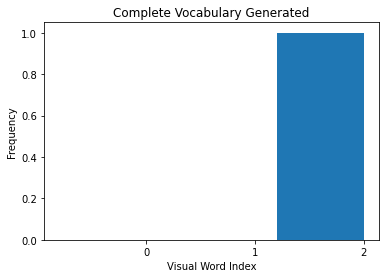

In [ ]:
x_scalar = np.arange(3)
y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(3)])
plt.bar(x_scalar, y_scalar)
plt.xlabel("Visual Word Index")
plt.ylabel("Frequency")
plt.title("Complete Vocabulary Generated")
plt.xticks(x_scalar + 0.4, x_scalar)
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(im_features,image_classes)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

# **TESTING**

In [ ]:
test_path = '/content/drive/My Drive/CAL TECH/validate'
testing_names = os.listdir(test_path)
image_paths = []
dlist = []
image_classes = []
class_id = 0
def imglist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]
for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    class_path = imglist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1
des_list = []
for image_path in tqdm(image_paths):
    im = cv.imread(image_path)
    kpts, des = surf.detectAndCompute(im, None)
    des_list.append((image_path, des)) 
    dlist.append(des)
descriptors = des_list[0][1]
for image_path, descriptor in des_list[0:]:
    descriptors = np.vstack((descriptors, descriptor))

100%|██████████| 12/12 [00:02<00:00,  4.08it/s]


In [ ]:
k = 3
kmeans=KMeans(k,random_state=0).fit(descriptors)
test_features = np.array([np.zeros(3) for i in range(len(image_paths))])
for i in range(len(image_paths)):
    for j in range(len(dlist[i])):
        feature = dlist[i][j]
        feature = feature.reshape(1, descriptors.shape[1])
        idx = kmeans.predict(feature)
        test_features[i][idx] += 1

In [ ]:
name_dict =	{
        "0": "butterfly",
        "1": "binacular",
        "2": "bear",
    }
classes_names = ["butterfly","binacular","bear"]

In [ ]:
predictions = [name_dict[str(int(i))] for i in knn.predict(test_features)]
print("Test images classified.")

Test images classified.


true_class =['butterfly', 'butterfly', 'butterfly', 'butterfly', 'binacular', 'binacular', 'binacular', 'binacular', 'bear', 'bear', 'bear', 'bear']
prediction =['binacular', 'binacular', 'binacular', 'binacular', 'binacular', 'binacular', 'binacular', 'binacular', 'butterfly', 'butterfly', 'butterfly', 'butterfly']
accuracy =  0.3333333333333333
[[0 0 4]
 [0 4 0]
 [0 4 0]]


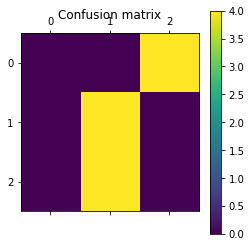

In [ ]:
true_class =  [classes_names[i] for i in image_classes]
print ("true_class ="  + str(true_class))
print ("prediction ="  + str(predictions))
accuracy = accuracy_score(true_class, predictions)
print ("accuracy = ", accuracy)
cm = confusion_matrix(true_class, predictions)
print (cm)
def showconfusionmatrix(cm):
    pl.matshow(cm)
    pl.title('Confusion matrix')
    pl.colorbar()
    pl.show()
showconfusionmatrix(cm)